In this notebook, we are going to make a text classification model using Neural Network and glove embedding.

The core dataset contains 50,000 reviews split evenly into 25k train and 25k test sets. The overall distribution of labels is balanced (25k pos and 25k neg).


In [1]:
import os
from gensim import models
import numpy as np
import pandas as pd
from tqdm import tqdm
tqdm.pandas()

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
embeddings_index = {}
f = open('../embeddings/glove.6B/glove.6B.50d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [11]:
embeddings_index["why"]

array([ 0.32386  ,  0.011154 ,  0.23443  , -0.18039  ,  0.6233   ,
       -0.059467 , -0.62369  ,  0.12782  , -0.40932  ,  0.083849 ,
       -0.19215  ,  0.57834  , -0.49637  , -0.048521 ,  1.099    ,
        0.6298   ,  0.26122  , -0.11049  ,  0.16728  , -0.71227  ,
       -0.371    ,  0.51635  ,  0.54567  ,  0.27623  ,  0.82096  ,
       -2.1861   , -1.0027   ,  0.11441  ,  0.53145  , -0.86653  ,
        2.5888   ,  0.37458  , -0.51935  , -0.68734  , -0.14537  ,
       -0.53177  , -0.065899 ,  0.0077695,  0.31162  , -0.17694  ,
       -0.36669  ,  0.17919  ,  0.21591  ,  0.61326  ,  0.41495  ,
        0.17295  , -0.19359  ,  0.26349  , -0.19398  ,  0.58678  ],
      dtype=float32)

In [13]:
from numpy import zeros
import keras
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.layers.embeddings import Embedding

In [14]:
# Reading data
train_df = pd.read_csv('../Data/imdb_master.csv', encoding = "ISO-8859-1")

In [15]:
train_df.head()

,Unnamed: 0,type,review,label,file
0,0,test,Once again Mr. Costner has dragged out a movie...,neg,0_2.txt
1,1,test,This is an example of why the majority of acti...,neg,10000_4.txt
2,2,test,"First of all I hate those moronic rappers, who...",neg,10001_1.txt
3,3,test,Not even the Beatles could write songs everyon...,neg,10002_3.txt
4,4,test,Brass pictures (movies is not a fitting word f...,neg,10003_3.txt


In [16]:
train_df = train_df.drop(["Unnamed: 0","file", "type"], axis=1)

In [17]:
train_df.label.value_counts()

unsup    50000
neg      25000
pos      25000
Name: label, dtype: int64

In [18]:
train_df = train_df[train_df.label != 'unsup']
train_df["label"] = train_df["label"].map({"pos":1,"neg":0})

In [19]:
train_df.head()

,review,label
0,Once again Mr. Costner has dragged out a movie...,0
1,This is an example of why the majority of acti...,0
2,"First of all I hate those moronic rappers, who...",0
3,Not even the Beatles could write songs everyon...,0
4,Brass pictures (movies is not a fitting word f...,0


In [20]:
# Cleaning and Pre Processing text
import re

def clean_numbers(text):
    text = re.sub('[0-9]{5,}', '#####', text)
    text = re.sub('[0-9]{4}', '####', text)
    text = re.sub('[0-9]{3}', '###', text)
    text = re.sub('[0-9]{2}', '##', text)
    return text

def clean_text(text):
    text = clean_numbers(text)
    text = str(text)

    for punct in "/-'":
        text = text.replace(punct, ' ')
    for punct in '&':
        text = text.replace(punct, f' {punct} ')
    for punct in '?!.,"$%\'()*+-/:;<=>@[\\]^_`{|}~' + '“”’':
        text = text.replace(punct, '')

    text = text.lower()
    return text

In [21]:
# Test the above pre process function
clean_text("Hi this Is the test For 894 y ~is okay")

'hi this is the test for ### y is okay'

In [22]:
# Clean text in dataFrame
train_df["processed_data"] = train_df["review"].progress_apply(lambda x: clean_text(x))
train_df["length"] = train_df["processed_data"].progress_apply(lambda x: len(x.split()))

100%|██████████| 50000/50000 [00:01<00:00, 48725.30it/s]


In [23]:
train_df.head(5)

,review,label,processed_data,length
0,Once again Mr. Costner has dragged out a movie...,0,once again mr costner has dragged out a movie ...,171
1,This is an example of why the majority of acti...,0,this is an example of why the majority of acti...,244
2,"First of all I hate those moronic rappers, who...",0,first of all i hate those moronic rappers who ...,232
3,Not even the Beatles could write songs everyon...,0,not even the beatles could write songs everyon...,321
4,Brass pictures (movies is not a fitting word f...,0,brass pictures movies is not a fitting word fo...,241


In [14]:
# The average length of sentences
train_df["length"].mean()

237.12282

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x118231f60>]],
      dtype=object)

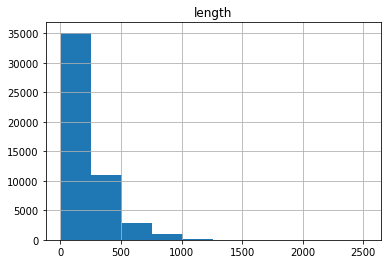

In [16]:
# Check the histogram 
train_df.hist("length")

In [25]:
docs = train_df["processed_data"].values
labels = train_df["label"].values

In [18]:
# Import gc, clearing some memory in ram
import gc
del train_df
gc.collect()

41

In [26]:
# prepare tokenizer
t = Tokenizer()
t.fit_on_texts(docs)
vocab_size = len(t.word_index) + 1

In [27]:
# integer encode the documents
encoded_docs = t.texts_to_sequences(docs)

In [31]:
print(docs[0])
print(encoded_docs[0])

once again mr costner has dragged out a movie for far longer than necessary aside from the terrific sea rescue sequences of which there are very few i just did not care about any of the characters most of us have ghosts in the closet and costner s character are realized early on and then forgotten until much later by which time i did not care the character we should really care about is a very cocky overconfident ashton kutcher the problem is he comes off as kid who thinks he s better than anyone else around him and shows no signs of a cluttered closet his only obstacle appears to be winning over costner finally when we are well past the half way point of this stinker costner tells us all about kutcher s ghosts we are told why kutcher is driven to be the best with no prior inkling or foreshadowing no magic here it was all i could do to keep from turning it off an hour in
[283, 176, 451, 7110, 47, 3382, 45, 3, 18, 16, 223, 1142, 73, 1724, 1171, 38, 1, 1311, 1617, 2142, 851, 4, 63, 40, 2

In [19]:


# pad documents to a max length of 4 words
max_length = 150
padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [20]:
# create a weight matrix for words in training docs
embedding_matrix = zeros((vocab_size, 50))
for word, i in t.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [21]:
# Create Train/Test data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    padded_docs, labels, test_size=0.2, random_state=42)

In [23]:
vocab_size = vocab_size

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 50, weights=[embedding_matrix], input_length=max_length, trainable=True))
model.add(keras.layers.GlobalAveragePooling1D())
model.add(keras.layers.Dense(64, activation=tf.nn.relu))
model.add(keras.layers.Dense(16, activation=tf.nn.relu) )
model.add(keras.layers.Dense(1, activation=tf.nn.sigmoid))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 150, 50)           7018250   
_________________________________________________________________
global_average_pooling1d_1 ( (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                3264      
_________________________________________________________________
dense_2 (Dense)              (None, 16)                1040      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 7,022,571
Trainable params: 7,022,571
Non-trainable params: 0
_________________________________________________________________


<img src="nn_diagram.png">

In [24]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [25]:
reduce_err = EarlyStopping(monitor='val_loss', 
                           min_delta=0,patience=0,
                           verbose=0, mode='auto')

In [26]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), 
          epochs=15, batch_size=512, callbacks=[reduce_err])

Train on 40000 samples, validate on 10000 samples
Epoch 1/15
40000/40000 [==============================] - 10s 255us/step - loss: 0.6650 - acc: 0.6137 - val_loss: 0.6152 - val_acc: 0.6806
Epoch 2/15
40000/40000 [==============================] - 12s 292us/step - loss: 0.5310 - acc: 0.7510 - val_loss: 0.4520 - val_acc: 0.7986
Epoch 3/15
40000/40000 [==============================] - 11s 285us/step - loss: 0.3819 - acc: 0.8356 - val_loss: 0.3624 - val_acc: 0.8457
Epoch 4/15
40000/40000 [==============================] - 10s 260us/step - loss: 0.2998 - acc: 0.8752 - val_loss: 0.3268 - val_acc: 0.8641
Epoch 5/15
40000/40000 [==============================] - 11s 285us/step - loss: 0.2463 - acc: 0.9022 - val_loss: 0.3094 - val_acc: 0.8737
Epoch 6/15
40000/40000 [==============================] - 11s 266us/step - loss: 0.2066 - acc: 0.9208 - val_loss: 0.3031 - val_acc: 0.8798
Epoch 7/15
40000/40000 [==============================] - 11s 265us/step - loss: 0.1726 - acc: 0.9360 - val_loss: 0.

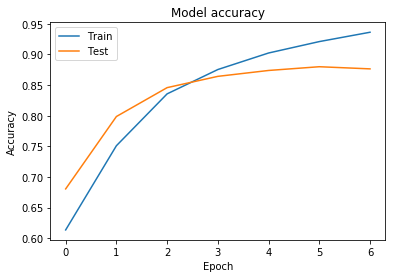

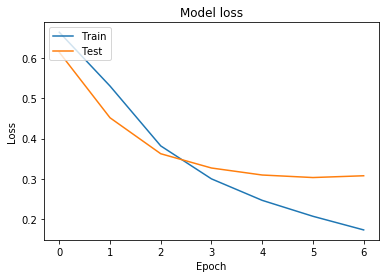

In [27]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()